In [ ]:
!pip install emoji

In [ ]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

In [ ]:
df = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding = 'latin')
df_test = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding = 'latin')

# Data Cleaning

In [ ]:
# Converting the "TweetAt" columns to pandas datetime format
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

In [ ]:
## check duplicates
df.duplicated().sum()

# Number of tweets per day :

In [ ]:
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='TweetAt', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

from the bar chart above, we notice that in the dataset there are some days without tweets in the dataset. Among the days with tweets, most of them are made around the end of March: from 18th of Match to the 26th of March.



# Number of tweets per Country & City

In [ ]:
tweets_per_country = df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

In [ ]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x='Location', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')
plt.title('Tweets count by country')
plt.xticks(rotation=70)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

The chart above explain that the 'location' column contains both countries and cities. It could be interesting to separate cities and countries, however this wont be investigated in this work.

# Data Preprocessing

we will just keep the columns 'Originaltweet' (raw tweets) and the target column 'Sentiment'.

In [ ]:
df = df[['OriginalTweet','Sentiment']]

In [ ]:
df_test = df_test[['OriginalTweet','Sentiment']]

In [ ]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return emoji.replace_emoji(text,replace = '') #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [ ]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [ ]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

Now we will create a new column, for both train and test sets, to host the cleaned version of the tweets' text.

In [ ]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [ ]:
df['text_clean'].head()

In [ ]:
df_test['text_clean'].head()

In [ ]:
df['text_clean'][1:8].values

Moreover, we will also create a column to host the lenght of the cleaned text, to check if by cleaning the text we removed too much text or almost entirely the tweet!

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [ ]:
df['text_len'] = text_len

In [ ]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [ ]:
df_test['text_len'] = text_len_test

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

As we can see, there are lots of cleaned tweets with 0 words: this is due to the cleaning performed before. This means that some tweets contained only mentions, hashtags and links, which have been removed. We will drop these empty tweets and also those with less than 5 words.

In [ ]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

In [ ]:
df = df[df['text_len'] > 4]

In [ ]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

We will use bert tokenizer to perform tokenization


[ ]
23s


In [ ]:
from transformers import BertTokenizerFast

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

Let's check the long tokenized sentences (with more than 80 tokens ):

In [ ]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  

These sentences are not in english. They should be dropped.


In [ ]:
df['token_lens'] = token_lens

In [ ]:
df = df.iloc[12:]
df.head()

The dataset looks more clean now. We will shuffle it and reset the index.

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.to_csv('covid_19_Cleaned_data.csv')

# Test data deeper cleaning

We will perform the data cleaning based on the tokenized sentences on the test set.

In [ ]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

In [ ]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

In [ ]:
df_test['token_lens'] = token_lens_test

In [ ]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10) 

In [ ]:
df_test = df_test.iloc[5:]
df_test.head(3)

In [ ]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [ ]:
df_test.to_csv('Covid_19_Cleaned_TestData.csv')

# Machine Learning

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df_train= pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='ISO-8859-1')
df_test= pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='ISO-8859-1')
df = pd.concat([df_train,df_test])

In [5]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [6]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [8]:
df.Sentiment.value_counts()

Sentiment
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: count, dtype: int64

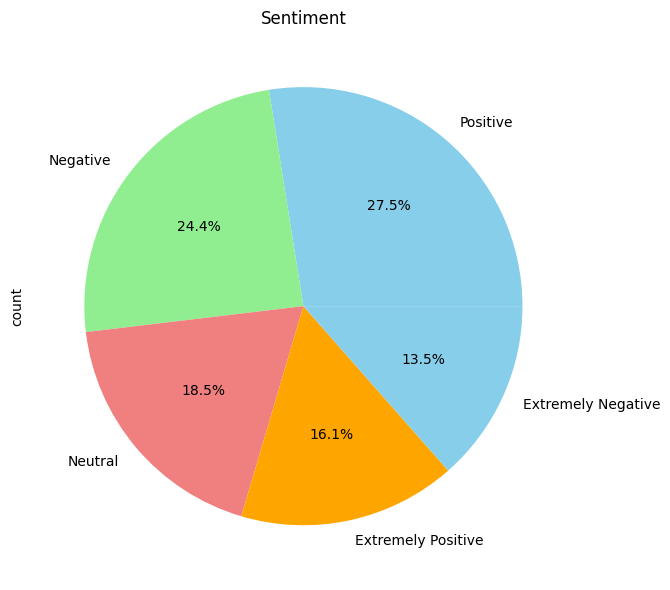

In [9]:
value_counts = df['Sentiment'].value_counts()
plt.figure(figsize=(8, 6))
value_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral', 'orange'])
plt.title('Sentiment')
plt.tight_layout()
plt.show()

In [10]:
df['Sentiment'] = df.Sentiment.str.replace('Extremely Positive', 'Positive')
df['Sentiment'] = df.Sentiment.str.replace('Extremely Negative', 'Negative')

Text(0, 0.5, 'Sentiment')

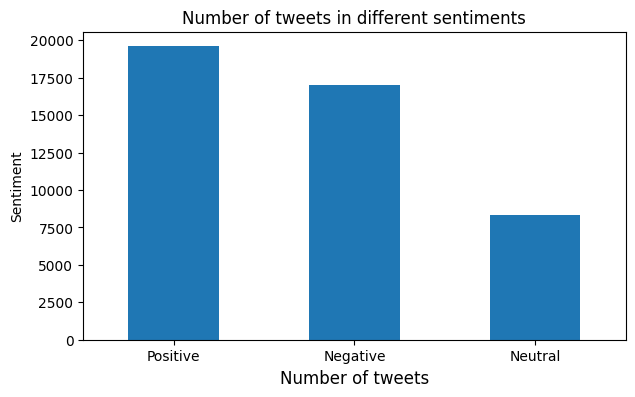

In [11]:
df.Sentiment.value_counts().plot.bar(figsize=(7,4))
plt.xticks(rotation=None)
plt.title('Number of tweets in different sentiments',fontsize=12)
plt.xlabel('Number of tweets', fontsize=12)
plt.ylabel('Sentiment')

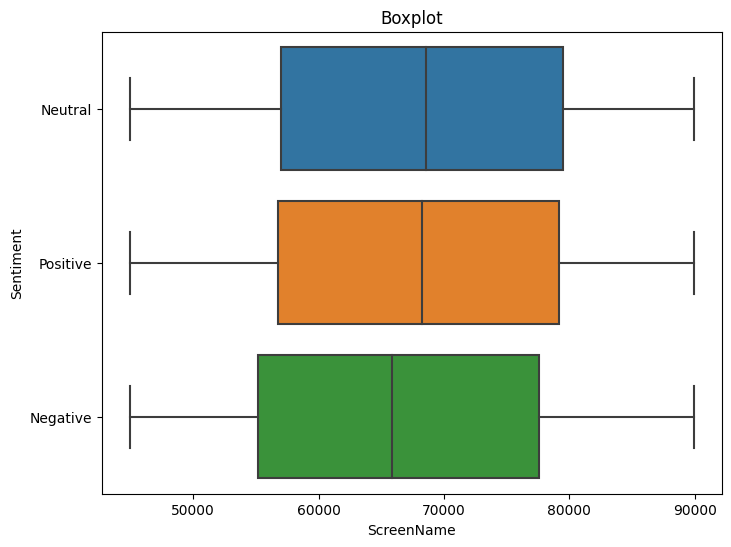

In [12]:
plt.figure(figsize=(8, 6))
sns.boxplot(df, x='ScreenName', y='Sentiment')
plt.title("Boxplot")
plt.show()

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [14]:
comp_df = df[['OriginalTweet','Sentiment']]

In [15]:
comp_df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Negative


In [16]:
comp_df['OriginalTweet'][0]

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
0    TRENDING: New Yorkers encounter empty supermar...
Name: OriginalTweet, dtype: object

In [17]:
comp_df.columns =['tweet','label']

In [18]:
import re
import nltk
from nltk.corpus import stopwords
def text_cleaner(tweet):   
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)  
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])   
    return tweet

stop_words = stopwords.words('english')

comp_df.tweet = comp_df.tweet.apply(text_cleaner)

/tmp/ipykernel_30/3204402080.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.tweet = comp_df.tweet.apply(text_cleaner)


In [20]:
comp_df.tweet[0]

0                                                     
0    TRENDING: New Yorkers encounter empty supermar...
Name: tweet, dtype: object

In [21]:
comp_df['corpus'] = [nltk.word_tokenize(text) for text in comp_df.tweet]
lemma = nltk.WordNetLemmatizer()
comp_df.corpus = comp_df.apply(lambda x: " ".join(x.corpus),axis=1)

/tmp/ipykernel_30/4056392135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['corpus'] = [nltk.word_tokenize(text) for text in comp_df.tweet]
/tmp/ipykernel_30/4056392135.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.corpus = comp_df.apply(lambda x: " ".join(x.corpus),axis=1)


In [22]:
text = comp_df.corpus.values
wordcloud = WordCloud(max_words=500,background_color='white', stopwords=stop_words, colormap='rainbow',height=300)
wordcloud.generate(str(text))

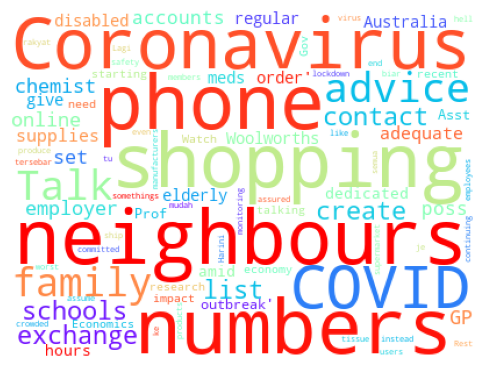

In [30]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(6)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [25]:
X = comp_df['tweet']
y = comp_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [26]:
vectorizer = TfidfVectorizer(max_features=72500)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [27]:
model = LogisticRegression(max_iter=72500)
model.fit(X_train_vectorized, y_train)
y_pred = model.predict(X_test_vectorized)

In [28]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy*100)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 81.78178178178179
Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.83      0.82      3330
     Neutral       0.77      0.65      0.71      1686
    Positive       0.83      0.88      0.86      3975

    accuracy                           0.82      8991
   macro avg       0.81      0.79      0.80      8991
weighted avg       0.82      0.82      0.82      8991



Text(0.5, 14.722222222222216, 'Predicted')

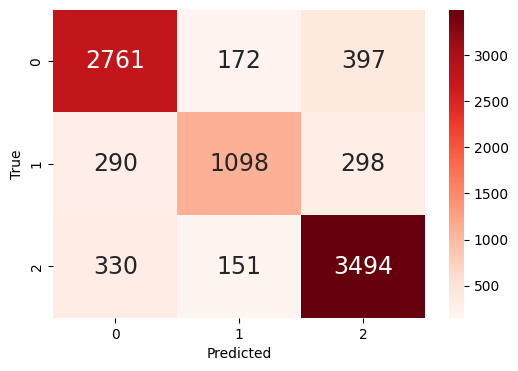

In [29]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',annot_kws={'size':17}, cmap='Reds')
plt.ylabel('True')
plt.xlabel('Predicted')

In [31]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train_vectorized ,y_train)

SVC()

In [33]:
predictions = model.predict(X_test_vectorized )

In [34]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy*100)
print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 80.75853631409187
Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.82      0.81      3330
     Neutral       0.79      0.63      0.70      1686
    Positive       0.82      0.87      0.85      3975

    accuracy                           0.81      8991
   macro avg       0.80      0.77      0.78      8991
weighted avg       0.81      0.81      0.81      8991



# NLP with LTSM

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from tensorflow.keras.preprocessing import text 
from tensorflow.keras.preprocessing import sequence 
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as layer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords

In [ ]:
df

In [ ]:
x = df['OriginalTweet']
y = df['Sentiment']

In [ ]:
#Cleaning the texts and getting rid of unclear symbols or characters
#This function is from: https://www.kaggle.com/code/shahraizanwar/covid19-tweets-sentiment-prediction-rnn-85-acc
import re
def text_cleaner(tweet):   
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)  
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])   
    return tweet

stop_words = stopwords.words('english')

X_c = x.apply(text_cleaner)
X_c.head()

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_c)

X = tokenizer.texts_to_sequences(X_c)
vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(X_c[8]))
print("\nAfter tokenizing :\n{}".format(X[8]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[8]))

In [ ]:
sentiments = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }
y = y.map(sentiments)
labels = ['Negative', 'Neutral', 'Positive']

In [ ]:
X_test = df_test['OriginalTweet'].copy()
y_test = df_test['Sentiment'].copy()

X_test = X_test.apply(text_cleaner)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post', maxlen = X.shape[1])

y_test = y_test.map(sentiments)

In [ ]:
def generic_model(model_layer,units, epochs, bs):
    EPOCHS = epochs
    BATCH_SIZE = bs
    embedding_dim = 16

    model= tf.keras.Sequential([
        layer.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
        model_layer(units,return_sequences = True),
        layer.GlobalMaxPooling1D(),
        layer.Dense(3,activation = 'softmax')
    ])
    
    model.summary()
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

    model.compile(loss=SparseCategoricalCrossentropy(from_logits = False),
              optimizer='adam',metrics=['accuracy'])
            
    history = model.fit(X, y, epochs=EPOCHS, 
                        validation_split=0.15, batch_size=BATCH_SIZE,
                        callbacks = [callback])
    hist_model = pd.DataFrame(history.history)
    
    #Plot the loss and accuracy curves
    fig, ax = plt.subplots(2,1, figsize = (8,8))
    ax[0].plot(hist_model.loss, c = 'b')
    ax[0].plot(hist_model.val_loss, c = 'r')
    ax[0].set_title('Training and validation losses');
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(hist_model.accuracy, c = 'b')
    ax[1].plot(hist_model.val_accuracy, c = 'r')
    ax[1].set_title('Training and validation accuracies');
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    
    #Prediction
    pred = np.argmax(np.round(model.predict(X_test)),axis = 1)
    loss, acc = model.evaluate(X_test,y_test,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
    
                 
    #Confustion matrix
    confm = confusion_matrix(y_test, pred)
    cm= pd.DataFrame(confm, index = [i for i in labels],
                    columns = [i for i in labels])

    plt.figure(figsize = (8,6))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.show()
                
    return model, hist_model, loss, acc, cm

In [ ]:
model_RNN = generic_model(layer.SimpleRNN, 20, 10, 32)

In [ ]:
model_LSTM = generic_model(layer.LSTM,15, 10, 32)

In [ ]:
Model: "sequential_6"